In [1]:
import datetime

import numpy as np
import pandas as pd
import gudhi

from traffic.core import Traffic, Flight
from functions.data_filtering import ICAO_codes, large_gap_filter
from functions.data_processing import flight_pers, remove_outliers_z_score, remove_outliers_dbscan
from functions.data_loading import linkage_cluster_persistances, flights_from_query

from scipy.cluster.hierarchy import fcluster

Removing C:\Users\tobso\AppData\Local\opensky\opensky\Cache\11cab217422a46668bdd431bc9c1bc6b.parquet created on 1732287253.090121
Removing C:\Users\tobso\AppData\Local\opensky\opensky\Cache\17d533508db6876e3c66891b0fa949a4.parquet created on 1732287071.572818
Removing C:\Users\tobso\AppData\Local\opensky\opensky\Cache\208413cefbb8c7bc47a2f7e61f7c9130.parquet created on 1732287016.9660704
Removing C:\Users\tobso\AppData\Local\opensky\opensky\Cache\2693ab50794d6360822c88b69d540286.parquet created on 1732286896.1110659
Removing C:\Users\tobso\AppData\Local\opensky\opensky\Cache\2afc3c94ce3879ebc67e6ab0a766c702.parquet created on 1732287367.607226
Removing C:\Users\tobso\AppData\Local\opensky\opensky\Cache\2b66c7d1c2651eed1b8c4715b63bda21.parquet created on 1732287456.4122007
Removing C:\Users\tobso\AppData\Local\opensky\opensky\Cache\354f32a5dc68722d1f79ecb3aac7c84c.parquet created on 1732286954.5981617
Removing C:\Users\tobso\AppData\Local\opensky\opensky\Cache\5e85c03effa5129a51267eeb87

In [2]:
# load minimum data set
df = pd.read_csv("../../data/go_arounds_augmented.csv", low_memory=False)
df["time"] = pd.to_datetime(df["time"])

start = datetime.datetime(year=2019, month=1, day=1).replace(
    tzinfo=datetime.timezone.utc
)
stop = datetime.datetime(year=2019, month=1, day=15).replace(
    tzinfo=datetime.timezone.utc
)

with_GA = df.query(f"has_ga & (@start <= time <= @stop)")
without_GA = df.query(f"not has_ga & (@start <= time <= @stop)")

In [3]:
# The flights can be converted into a Traffic object
count = with_GA.shape[0]
with_GA_flights = flights_from_query(with_GA, count, "../../data/with_GA_flights.pkl")
without_GA_flights = flights_from_query(without_GA, count, "../../data/without_GA_flights.pkl")

In [4]:
with_GA_flights = list(filter(large_gap_filter, with_GA_flights))
without_GA_flights = list(filter(large_gap_filter, without_GA_flights))

with_GA_labels = np.ones(len(with_GA_flights))
without_GA_labels = np.zeros(len(without_GA_flights))

flights = with_GA_flights + without_GA_flights
labels = np.concatenate((with_GA_labels, without_GA_labels))

trees, paths = flight_pers(flights)

100%|██████████| 1388/1388 [00:37<00:00, 36.64it/s]


In [5]:
print(len(with_GA_flights))
print(len(without_GA_flights))

705
683


In [6]:
path = f"../../data/linkage_clustering/cyclic_dataset.pkl"
Z = linkage_cluster_persistances(trees, path=path, dimension=1, load_results=True)

In [7]:
clustering = fcluster(Z, t=10, criterion='maxclust')

for i in range(1, len(np.unique(clustering))+1):
    print(f"{i}: {sum(clustering == i)}")

1: 10
2: 1
3: 1314
4: 1
5: 19
6: 25
7: 5
8: 12
9: 1
10: 1


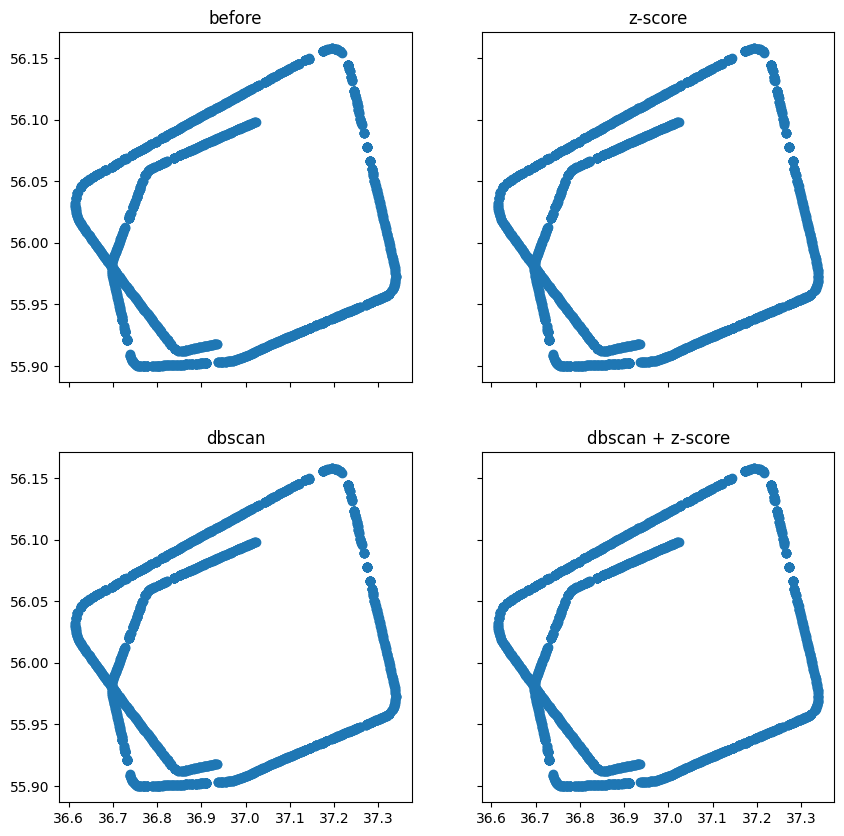

In [27]:
from matplotlib import pyplot as plt

ind = 8

flight = flights[np.where(clustering == ind)[0][4]]
before = flight.data[["longitude", "latitude"]].to_numpy()

dbscan_paths        = before[remove_outliers_dbscan(before, 10)]
z_score_paths       = before[remove_outliers_z_score(before)]
both_bethods_paths  = dbscan_paths[remove_outliers_z_score(dbscan_paths)]

path_filters = [(before, "before"), (z_score_paths, "z-score"), (dbscan_paths, "dbscan"), (both_bethods_paths, "dbscan + z-score")]

fig, axs = plt.subplots((len(path_filters)+1)//2, 2, sharex=True, sharey=True)
for i, (path, name) in enumerate(path_filters):
    axs[i//2, i%2].scatter(path[:, 0], path[:, 1])
    axs[i//2][i%2].set_title(name)

fig.set_figheight(10)
fig.set_figwidth(10)

<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

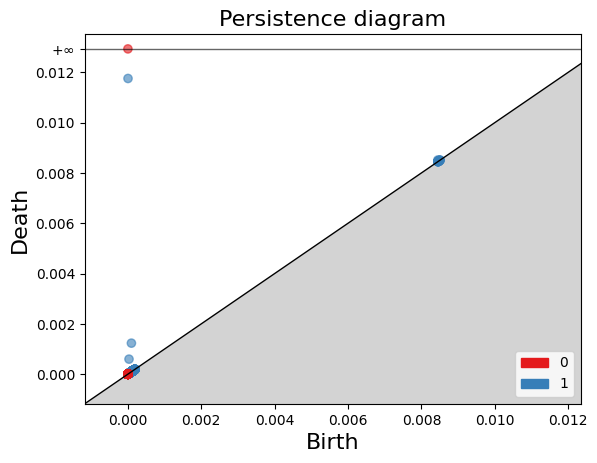

In [31]:
tree = trees[np.where(clustering == ind)[0][4]]
points = paths[np.where(clustering == ind)[0][4]]
gudhi.plot_persistence_diagram(tree.persistence())

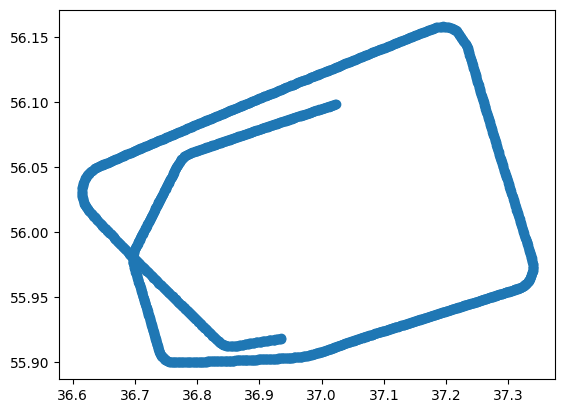

In [32]:
fig = plt.scatter(points[:, 1], points[:, 0])
plt.show()